## RAVITEJA Y S - 213010042
## SHREYAS G S - 213010040

In [3]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================


-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.


In [4]:


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Here I have used the Direct google drive to import the downloaded Hymenoptera data

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



data_dir = '/content/gdrive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


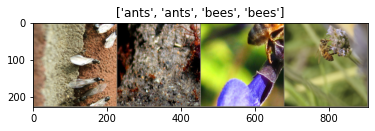

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    val_loss = np.zeros(num_epochs)  #We are initializing the val_loss and vall_acc
    val_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
  

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
              val_loss[epoch] = epoch_loss  #Here as we need only validation loss plot, we are iterating for the numbers based on every epoch
              val_acc[epoch] = epoch_acc

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

#Plotting the Validation LOSS AND VALIDATION ACCURACY FOR THE EPOCHS
    plt.plot(val_loss,label ="val_loss")
    plt.plot(val_acc,label ="val_acc")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Validation')
    plt.title('Validation accuracy')
    plt.legend()
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




## Case 1
We are using the default settings given in the tutorial. Epochs are 25, learning rate=0.001, momentum=0.9.
For this case we have plotted the validation loss and accuracy plots for the number of epochs that we took and is shown below.

In [25]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4943 Acc: 0.7705
val Loss: 0.2210 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6413 Acc: 0.7459
val Loss: 0.2859 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6061 Acc: 0.7828
val Loss: 0.3428 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.6713 Acc: 0.7746
val Loss: 0.3614 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4414 Acc: 0.8156
val Loss: 0.7633 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.4422 Acc: 0.8156
val Loss: 0.3106 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3530 Acc: 0.8607
val Loss: 0.2772 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4253 Acc: 0.8566
val Loss: 0.2146 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3289 Acc: 0.8689
val Loss: 0.2078 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3507 Acc: 0.8402
val Loss: 0.2010 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2919 Acc: 0.8730
val Loss: 0.2251 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3268 Acc: 0.8689
val Loss: 0.2208 Acc: 0.9150

Epoch 12/24
----------
t

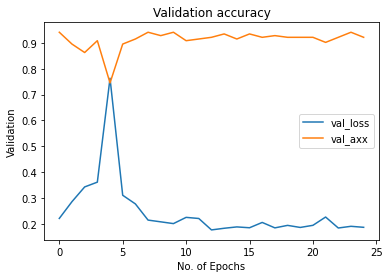

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


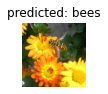

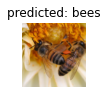

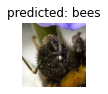

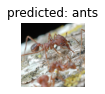

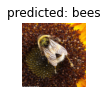

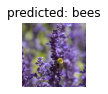

In [27]:
visualize_model(model_ft)

## Case 2

We are using the other settings given in the tutorial. Epochs are 15, learning rate=0.001, momentum=0.8.
For this case we have plotted the validation loss and accuracy plots for the number of epochs that we took and is shown below.

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5930 Acc: 0.6885
val Loss: 0.2679 Acc: 0.9085

Epoch 1/14
----------
train Loss: 0.4473 Acc: 0.8033
val Loss: 0.1808 Acc: 0.9346

Epoch 2/14
----------
train Loss: 0.5266 Acc: 0.7582
val Loss: 0.1867 Acc: 0.9346

Epoch 3/14
----------
train Loss: 0.2651 Acc: 0.8852
val Loss: 0.1773 Acc: 0.9412

Epoch 4/14
----------
train Loss: 0.3432 Acc: 0.8607
val Loss: 0.1742 Acc: 0.9477

Epoch 5/14
----------
train Loss: 0.3021 Acc: 0.8607
val Loss: 0.1702 Acc: 0.9542

Epoch 6/14
----------
train Loss: 0.4553 Acc: 0.8033
val Loss: 0.1354 Acc: 0.9542

Epoch 7/14
----------
train Loss: 0.3617 Acc: 0.8443
val Loss: 0.1643 Acc: 0.9608

Epoch 8/14
----------
train Loss: 0.2523 Acc: 0.9180
val Loss: 0.1547 Acc: 0.9542

Epoch 9/14
----------
train Loss: 0.2127 Acc: 0.8893
val Loss: 0.1533 Acc: 0.9542

Epoch 10/14
----------
train Loss: 0.3122 Acc: 0.8648
val Loss: 0.1649 Acc: 0.9477

Epoch 11/14
----------
train Loss: 0.3587 Acc: 0.8279
val Loss: 0.1406 Acc: 0.9477

Epoch 12/14
----------
t

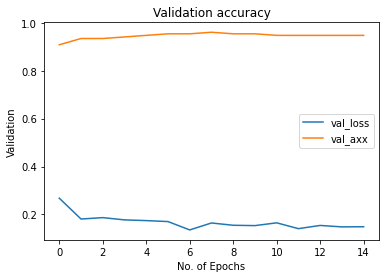

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

## Case 3

We are using the other settings. Epochs are 10, learning rate=0.05, momentum=0.9.
For this case we have plotted the validation loss and accuracy plots for the number of epochs that we took and is shown below.

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 8.9362 Acc: 0.5410
val Loss: 45.7996 Acc: 0.5425

Epoch 1/9
----------
train Loss: 5.4792 Acc: 0.4959
val Loss: 0.7484 Acc: 0.5425

Epoch 2/9
----------
train Loss: 1.6767 Acc: 0.4836
val Loss: 0.7553 Acc: 0.4575

Epoch 3/9
----------
train Loss: 0.9972 Acc: 0.5246
val Loss: 1.1831 Acc: 0.3987

Epoch 4/9
----------
train Loss: 0.9832 Acc: 0.4672
val Loss: 1.1109 Acc: 0.4575

Epoch 5/9
----------
train Loss: 0.8012 Acc: 0.5287
val Loss: 0.7193 Acc: 0.5229

Epoch 6/9
----------
train Loss: 0.7111 Acc: 0.5205
val Loss: 0.7408 Acc: 0.4902

Epoch 7/9
----------
train Loss: 0.7074 Acc: 0.5246
val Loss: 0.7224 Acc: 0.4575

Epoch 8/9
----------
train Loss: 0.6997 Acc: 0.4590
val Loss: 0.6804 Acc: 0.5752

Epoch 9/9
----------
train Loss: 0.6930 Acc: 0.5410
val Loss: 0.7493 Acc: 0.5882

Training complete in 1m 1s
Best val Acc: 0.588235


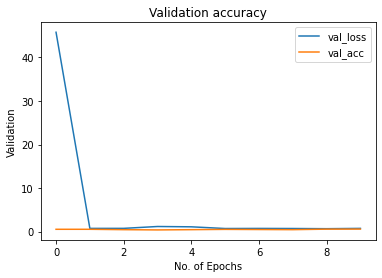

In [31]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.05, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

## Case 4

We are using the other settings. Epochs are 15, learning rate=0.001, momentum=0.5.
For this case we have plotted the validation loss and accuracy plots for the number of epochs that we took and is shown below.

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5827 Acc: 0.6639
val Loss: 0.3261 Acc: 0.9085

Epoch 1/14
----------
train Loss: 0.4688 Acc: 0.7664
val Loss: 0.3146 Acc: 0.8954

Epoch 2/14
----------
train Loss: 0.5076 Acc: 0.7295
val Loss: 0.2364 Acc: 0.9281

Epoch 3/14
----------
train Loss: 0.3681 Acc: 0.8525
val Loss: 0.1939 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.3574 Acc: 0.8361
val Loss: 0.1911 Acc: 0.9477

Epoch 5/14
----------
train Loss: 0.3485 Acc: 0.8566
val Loss: 0.2038 Acc: 0.9281

Epoch 6/14
----------
train Loss: 0.3940 Acc: 0.8115
val Loss: 0.1815 Acc: 0.9477

Epoch 7/14
----------
train Loss: 0.3317 Acc: 0.8238
val Loss: 0.1848 Acc: 0.9412

Epoch 8/14
----------
train Loss: 0.3146 Acc: 0.8566
val Loss: 0.1820 Acc: 0.9412

Epoch 9/14
----------
train Loss: 0.3462 Acc: 0.8320
val Loss: 0.1939 Acc: 0.9346

Epoch 10/14
----------
train Loss: 0.3089 Acc: 0.8811
val Loss: 0.1805 Acc: 0.9477

Epoch 11/14
----------
train Loss: 0.2940 Acc: 0.8689
val Loss: 0.1682 Acc: 0.9542

Epoch 12/14
----------
t

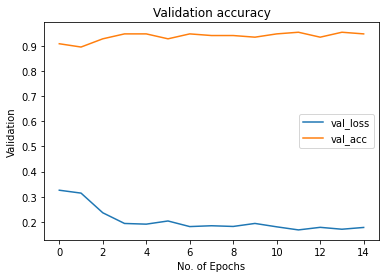

In [32]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

## Case 5

We are using the other settings. Epochs are 15, learning rate=0.0001, momentum=1.
For this case we have plotted the validation loss and accuracy plots for the number of epochs that we took and is shown below.

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6158 Acc: 0.6475
val Loss: 0.2836 Acc: 0.9020

Epoch 1/14
----------
train Loss: 0.5342 Acc: 0.7869
val Loss: 0.1922 Acc: 0.9150

Epoch 2/14
----------
train Loss: 0.7851 Acc: 0.7500
val Loss: 0.3940 Acc: 0.8824

Epoch 3/14
----------
train Loss: 1.1566 Acc: 0.7131
val Loss: 2.0084 Acc: 0.7320

Epoch 4/14
----------
train Loss: 1.8492 Acc: 0.6393
val Loss: 2.2337 Acc: 0.5817

Epoch 5/14
----------
train Loss: 2.8695 Acc: 0.5205
val Loss: 2.6656 Acc: 0.6601

Epoch 6/14
----------
train Loss: 2.4851 Acc: 0.6393
val Loss: 2.3789 Acc: 0.6797

Epoch 7/14
----------
train Loss: 1.9557 Acc: 0.5861
val Loss: 1.8807 Acc: 0.6013

Epoch 8/14
----------
train Loss: 1.3251 Acc: 0.5779
val Loss: 1.5921 Acc: 0.5882

Epoch 9/14
----------
train Loss: 1.0529 Acc: 0.5779
val Loss: 1.1871 Acc: 0.6013

Epoch 10/14
----------
train Loss: 1.1806 Acc: 0.5123
val Loss: 1.8901 Acc: 0.5817

Epoch 11/14
----------
train Loss: 0.8990 Acc: 0.6270
val Loss: 2.0900 Acc: 0.6797

Epoch 12/14
----------
t

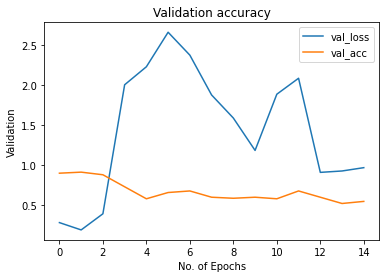

In [33]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

## Observation

As we can see from the plots we have changed the learning rate, number of epochs and the momentum for different cases. We can see the following observations from the plots.



*   The learning rate determines how quickly the model adapts to the situation. Given the smaller changes to the weights each update, lesser learning rates necessitate more training epochs, whereas greater learning rates necessitate fewer training epochs.
*   As we can see from the plots, we should Set the number of epochs as high as possible and stop training when the error rates are too high. To clarify, an epoch is a single learning cycle during which the learner observes the whole training data set. If there are two batches, the learner must complete two iterations for each epoch.



## References:

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/